In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from functools import partial
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope as ho_scope

In [2]:
# Importar la data
data = pd.read_csv('data.csv')

In [3]:
x = data.drop('actual_productivity', axis=1)
y = data['actual_productivity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=127, random_state=10)

### Modelo simple

In [4]:
# Definir el modelo Random forest
model_rf = RandomForestRegressor(random_state=10, criterion='absolute_error', bootstrap=False)

In [5]:
# Los parámetros que el modelo utiliza son

print('Parámetros por defecto del modelo:\n')
print(model_rf.get_params())

Parámetros por defecto del modelo:

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 10, 'verbose': 0, 'warm_start': False}


In [6]:
start = dt.now()
# Ajustar el modelo al conjunto de datos de entrenamiento
model_rf.fit(x_train, y_train)
end = dt.now()

In [7]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

8

In [8]:
# Valores predichos por el modelo
y_pred_train = model_rf.predict(x_train)
y_pred_test = model_rf.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train = mean_absolute_error(y_train, y_pred_train)
error_test = mean_absolute_error(y_test, y_pred_test)

In [9]:
# Se observa al aplicar un modelo random forest con sus parámetros por defecto
# el MAE para el conjunto de entrenamiento es de 0 y en el conjunto de pruebas es de 0.0775

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test))

MAE del conjunto de entrenamiento: 0.0000000
MAE del conjunto de prueba: 0.0775621


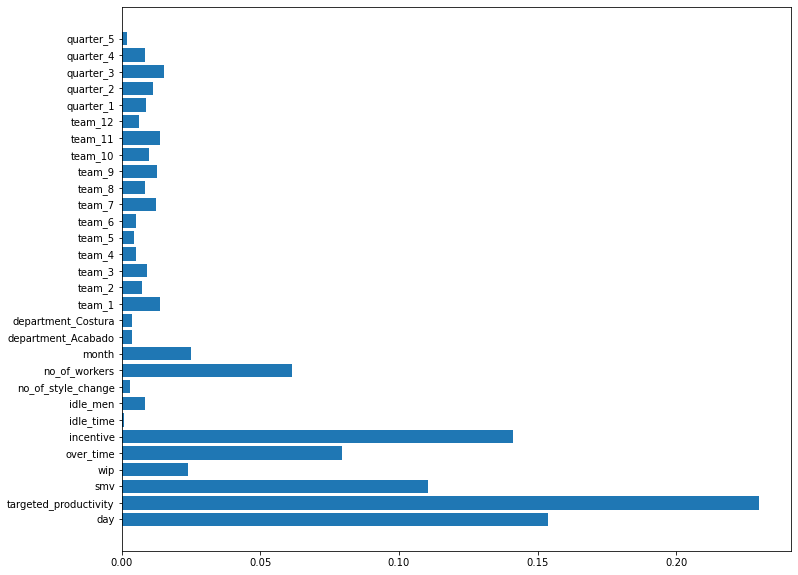

In [10]:
# Importancia de las variables para estimar la productividad

plt.figure(figsize=(12,10))
plt.barh(x_train.columns, model_rf.feature_importances_)
plt.show()

In [11]:
# Este modelo utilizó 100 estimadores
len(model_rf.estimators_)

100

### Modelo con ajuste de hiper parámetros

#### Grid search

In [12]:
# Crear la grilla de parámetros
param_grid = {
    'max_depth': [5, 10, 20, 30]
     ,'max_features': [10, 20, 30]
     ,'min_samples_leaf': [2, 5, 10]
     ,'min_samples_split': [2, 5, 10]
     ,'n_estimators': [50, 100, 200, 500, 1000]
}

In [13]:
# Definir el modelo Random forest
model_rf = RandomForestRegressor(random_state=10, criterion='absolute_error', bootstrap=False)

In [14]:
grid_search = GridSearchCV(estimator = model_rf
             , param_grid = param_grid
             , cv = 10
             , n_jobs = -1)

In [15]:
start = dt.now()
grid_search.fit(x_train, y_train)
end = dt.now()

In [16]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

23382

In [17]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

In [18]:
best_grid = grid_search.best_estimator_

In [19]:
joblib.dump(best_grid, 'resultados/random_forest_grid.pkl')

['resultados/random_forest_grid.pkl']

In [20]:
# Valores predichos por el modelo
y_pred_train_grid = best_grid.predict(x_train)
y_pred_test_grid = best_grid.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_grid = mean_absolute_error(y_train, y_pred_train_grid)
error_test_grid = mean_absolute_error(y_test, y_pred_test_grid)

In [21]:
# Se observa al aplicar un modelo random forest con un ajuste de hiper parámetros
# el MAE para el conjunto de entrenamiento es de 0.0421 y en el conjunto de pruebas es de 0.065

print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_grid))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_grid))

MAE del conjunto de entrenamiento: 0.0419241
MAE del conjunto de prueba: 0.0664803


#### Optimización bayesiana

In [22]:
def optimize(search_space):
    model = RandomForestRegressor(**search_space)
    scores = cross_val_score(model, X=x_train, y=y_train, cv=10, scoring='neg_mean_absolute_error').mean()
    
    return {'loss':scores, 'status': STATUS_OK, 'model': model}

In [23]:
search_space = {
    'criterion': 'absolute_error',
    'random_state': 10,
    'max_depth': hp.quniform('max_depth', 3, 30, 1),
    'max_features': hp.choice('max_features', [10, 20, 30]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [2, 5, 10]),
    'min_samples_split' : hp.choice ('min_samples_split', [2, 5, 10]),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators', 50, 1000, 1))
}

In [24]:
optimization_function = partial(
    optimize
)

In [25]:
trials = Trials()
start = dt.now()

result = fmin(
    fn = optimization_function
    , space = search_space
    , max_evals = 200
    , trials=trials
    , algo = tpe.suggest
)

end = dt.now()

100%|███████████████████████████████████████████| 200/200 [3:12:28<00:00, 57.74s/trial, best loss: -0.0975854544113944]


In [26]:
# Tiempo que se requiere para ajustar el modelo
(end - start).seconds

11548

In [27]:
print(space_eval(search_space, result))

{'criterion': 'absolute_error', 'max_depth': 3.0, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 341, 'random_state': 10}


In [28]:
best_model_bo = trials.best_trial['result']['model']

In [29]:
joblib.dump(best_model_bo, 'resultados/random_forest_bo.pkl')

['resultados/random_forest_bo.pkl']

In [30]:
best_model_bo.fit(x_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=3.0,
                      max_features=10, min_samples_leaf=5, n_estimators=341,
                      random_state=10)

In [31]:
# Valores predichos por el modelo
y_pred_train_bo = best_model_bo.predict(x_train)
y_pred_test_bo = best_model_bo.predict(x_test)

# Calcular el error para el conjunto de entrenamiento y prueba
error_train_bo = mean_absolute_error(y_train, y_pred_train_bo)
error_test_bo = mean_absolute_error(y_test, y_pred_test_bo)

In [32]:
print('MAE del conjunto de entrenamiento: {:.7f}'.format(error_train_bo))
print('MAE del conjunto de prueba: {:.7f}'.format(error_test_bo))

MAE del conjunto de entrenamiento: 0.0947643
MAE del conjunto de prueba: 0.0883198


In [33]:
# trials.losses()

In [34]:
joblib.dump(trials, 'resultados/random_forest_bo_trials.pkl')

['resultados/random_forest_bo_trials.pkl']